
# Police Response Time Analysis
## Introduction

We down load the local road network, and download the locations of Queensland Police Stations.
We then plot both for a designated area (North Sunshine Coast), with an image to provide geographic context.

In [96]:
import osmnx as ox
import networkx as nx

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mpc
import matplotlib.cm as mcm

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

from shapely.geometry import Polygon
from shapely.geometry import LineString

In [4]:
%matplotlib inline

-------------------------------
## Cartopy Map - PlateCarree Projection

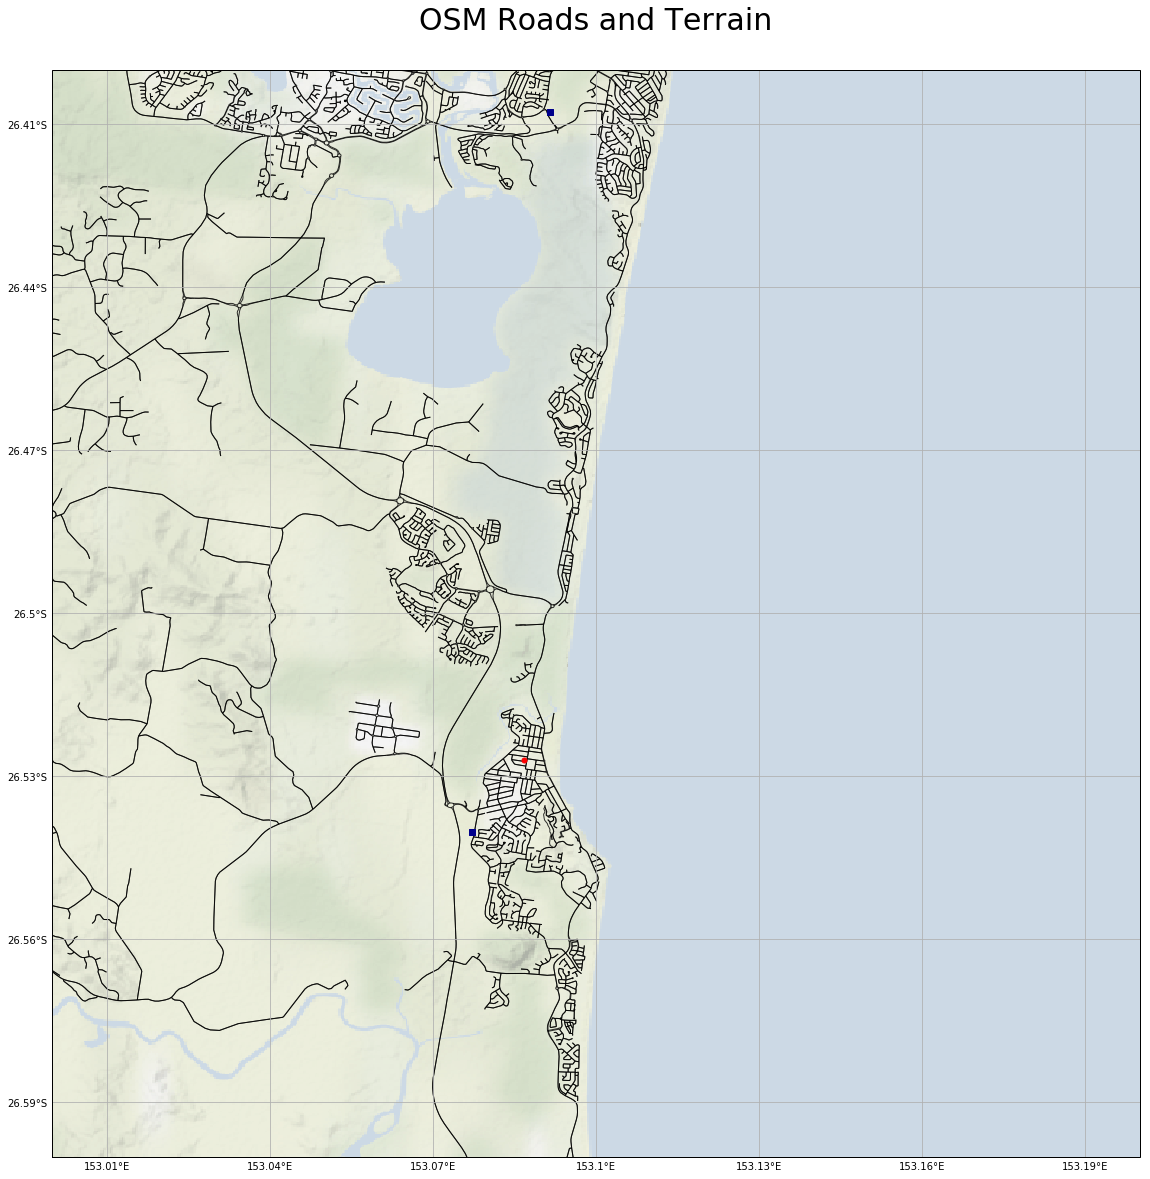

In [5]:
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/terrain-background/{}/{}/{}.png'.format(z, x, y)
        return url    
    #end _image_url
#end StamenToner

imagery = StamenToner()


fig = plt.figure(figsize=(20, 20) )
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree() ) 
               
home = ( 153, 153.2, -26.6, -26.4) #home = ( 152.5, 153.5, -27, -26)
ax.set_extent(home, crs=ccrs.PlateCarree() )


graph = ox.graph_from_bbox(home[3], home[2], home[1], home[0], network_type='drive', truncate_by_edge=True) 
n_df, e_df = ox.save_load.graph_to_gdfs(graph, nodes=True, edges=True)


ax.add_image(imagery, 12, alpha=0.5)
e_df.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none', zorder=1, alpha=0.8, )


# plot marker with lon / lat
home_lat, home_lon = -26.527,153.08679
ax.plot(home_lon, home_lat, marker='o', transform=ccrs.PlateCarree(), markersize=5, alpha=1, color='red', zorder=5 )

station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
police_df.plot(ax=ax, marker='s', color='darkblue', zorder=5, legend=True)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('OSM Roads and Terrain', {'fontsize':30}, pad=40)

plt.show()


## Get Nodes in Road Network Closest to Police Stations

In [26]:
# home = ( 153, 153.2, -26.6, -26.4)
map_poly = Polygon([(home[0], home[2]), (home[1], home[2]), (home[1], home[3]), (home[0], home[3])])



In [27]:
stations_pts = [x for x in police_df['geometry'] if x.within(map_poly)]

In [28]:
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
stations_pts = [x for x in police_df['geometry'] if x.within(map_poly)]


In [29]:
[x.xy for x in stations_pts]

[(array('d', [153.077204]), array('d', [-26.540297])),
 (array('d', [153.09158300026934]), array('d', [-26.407834000005323]))]

In [30]:
stations_pts[0].xy[0][0]

153.077204

In [31]:
pol_nodes = [ox.utils.get_nearest_node(graph, (station.xy[1][0], station.xy[0][0])) for station in stations_pts] 

In [32]:
print(pol_nodes)

[410116177, 1754416227]


In [13]:
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)

In [14]:
local = police_df[police_df['geometry'].within(map_poly)]

In [15]:
local.head()



,NAME,geometry
73,COOLUM STATION,POINT (153.077204 -26.540297)
235,NOOSA HEADS STATION,POINT (153.0915830002693 -26.40783400000532)


-----------------------------
## Cartopy Map in UTM Coordinate System

In [16]:
def label_utm_grid2(ax):
    ''' Warning: should only use with small area UTM maps '''    

    for val,label in zip(ax.get_xticks(), ax.get_xticklabels()):
        label.set_text(str(val))
        label.set_position((val,0))  

    for val,label in zip(ax.get_yticks(), ax.get_yticklabels()):   
        label.set_text(str(val))
        label.set_position((0,val))  

    plt.tick_params(bottom=True,top=True,left=True,right=True,
            labelbottom=True,labeltop=False,labelleft=True,labelright=False)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    plt.grid(True)

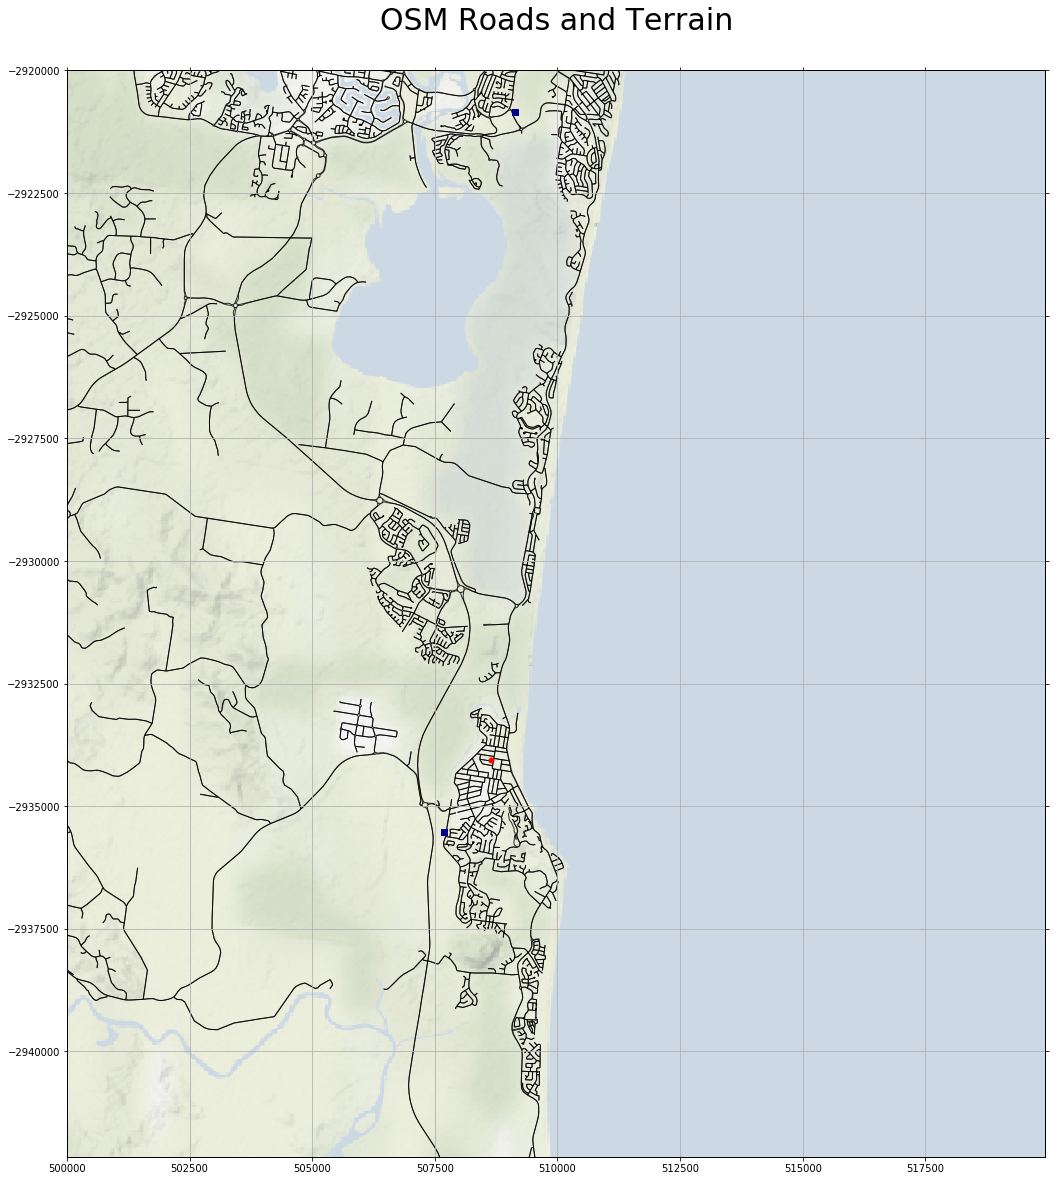

In [17]:
#  get OSM road network
graph = ox.graph_from_bbox(home[3], home[2], home[1], home[0], network_type='drive', truncate_by_edge=True, ) 

# convert to GDFs
n_df, e_df = ox.save_load.graph_to_gdfs(graph, nodes=True, edges=True)

# switch to UTM (so euclidean measurement works)
n_df = ox.projection.project_gdf(n_df)
e_df = ox.projection.project_gdf(e_df)

fig = plt.figure(figsize=(20, 20) )
utm_crs = ccrs.UTM(e_df.crs['zone'], southern_hemisphere=False)
ax = fig.add_subplot(1, 1, 1, projection= utm_crs) 
               
home = ( 153, 153.2, -26.6, -26.4) #home = ( 152.5, 153.5, -27, -26)
ax.set_extent(home, crs=ccrs.PlateCarree() )

# add spatial context
ax.add_image(imagery, 12, alpha=0.5)

# plot road network
e_df.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none', zorder=1, alpha=0.8, )


# plot marker with lon / lat
home_lat, home_lon = -26.527,153.08679
ax.plot(home_lon, home_lat, marker='o', transform=ccrs.PlateCarree(), markersize=5, alpha=1, color='red', zorder=5 )

# read police station locations
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
# project to UTM
police_df = police_df.to_crs(utm_crs.proj4_init)
# plot stations
police_df.plot(ax=ax, marker='s', color='darkblue', zorder=5, legend=True)

# set title and grid
label_utm_grid2(ax)
plt.title('OSM Roads and Terrain', {'fontsize':30}, pad=40)

plt.show()

-----------------
## Map Created by OSMNX with single station response times

In [18]:
trip_times = [1, 5, 10, 15, 20,] #in minutes
iso_colors = ox.get_colors(n=len(trip_times), cmap='viridis', start=0.0, stop=1.0, return_hex=True)

travel_speed = 80 #walking speed in km/hour
meters_per_min = travel_speed*1000/60

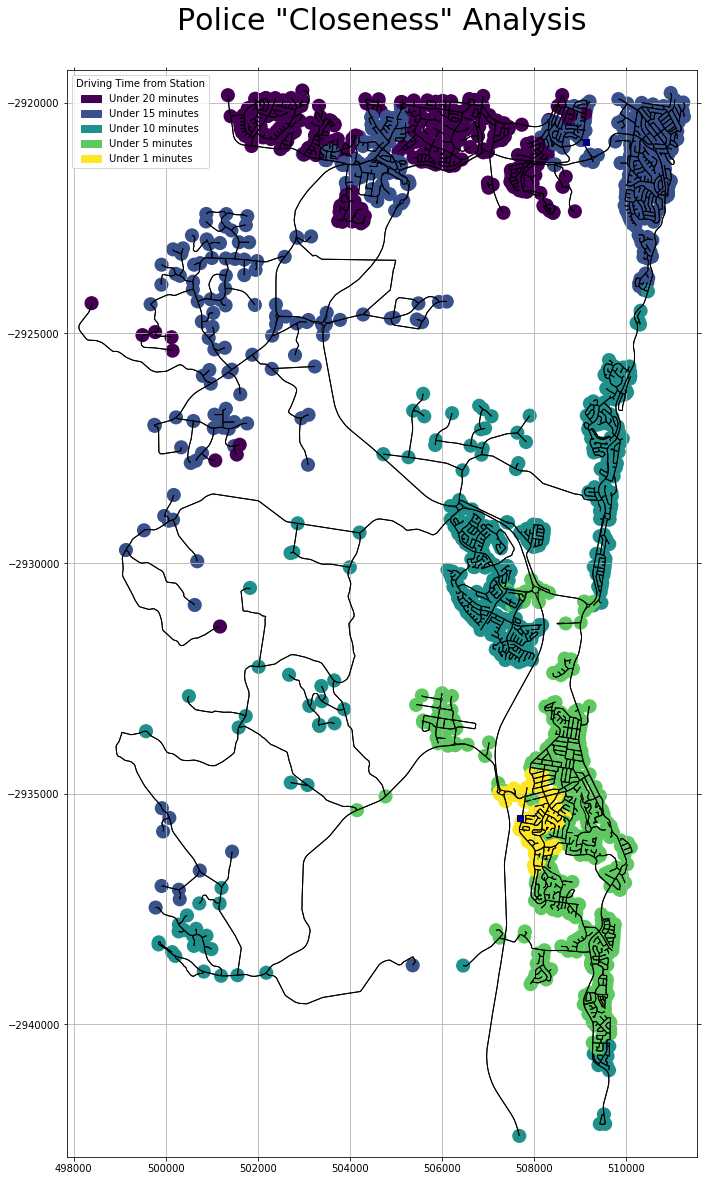

In [20]:
home = ( 153, 153.2, -26.6, -26.4) 
graph = ox.graph_from_bbox(home[3], home[2], home[1], home[0], network_type='drive', truncate_by_edge=True, ) 
graph = ox.project_graph(graph)

for u,v, k, data in graph.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_min
#end for

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph, pol_nodes[0], radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
    #end for
#end for
nc = [node_colors[node] if node in node_colors else 'none' for node in graph.nodes() ]
ns = [200 if node in node_colors else 0 for node in graph.nodes()]

fig, ax = ox.plot_graph(graph, fig_height=20, 
                        node_color=nc, node_size=ns, node_zorder=1, node_alpha=1,
                        edge_color='black', 
                       show=False, save=False, close=False, axis_off=False,
                       )

# read police station locations
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
# project to UTM
police_df = police_df.to_crs(utm_crs.proj4_init)
# plot stations
police_df.plot(ax=ax, marker='s', color='darkblue', zorder=5, legend=True)


label_utm_grid2(ax)

# handles is a list of patch handles
handles = []
# names is the list of corresponding labels to appear in the legend
names = []

# for each cartopy defined color, draw a patch, append handle to list, and append color name to names list
for c, t  in zip(iso_colors, sorted(trip_times, reverse=True)):
    label = 'Under '+str(t)+' minutes'
    patch = mpatches.Patch(color=c, label=label)
    handles.append(patch)
    names.append(label)
#end for

ax.legend(handles, names, title='Driving Time from Station')
plt.title('Police "Closeness" Analysis', {'fontsize':30}, pad=40)


plt.show()


In [19]:
pol_nodes

[410116177, 1754416227]

In [38]:
police_df.head()

,NAME,geometry
0,ACACIA RIDGE STATION,POINT (153.026536000353 -27.58819799995126)
1,ADAVALE STATION,POINT (144.5974909997149 -25.91081900032646)
2,AGNES WATER STATION,POINT (151.907981 -24.212576)
3,ALBANY CREEK STATION,POINT (152.9651980003101 -27.344526000423)
4,ALLORA STATION,POINT (151.9845919999407 -28.03528800019978)


In [54]:
e_df.head()

,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v,width
0,NaN,"LINESTRING (153.0673085 -26.5016426, 153.06791...",residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,NaN,4367056896,4367056897,NaN
1,NaN,"LINESTRING (153.0673085 -26.5016426, 153.06778...",residential,NaN,0,NaN,94.648,NaN,NaN,False,184866396,NaN,NaN,4367056896,4367056187,NaN
2,NaN,"LINESTRING (153.0673085 -26.5016426, 153.06703...",residential,NaN,0,NaN,78.167,NaN,NaN,False,184866396,NaN,NaN,4367056896,1954348651,NaN
3,NaN,"LINESTRING (153.0679123 -26.5011789, 153.06730...",residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,NaN,4367056897,4367056896,NaN
4,NaN,"LINESTRING (153.0866292 -26.5558007, 153.08587...",residential,NaN,0,NaN,75.478,NaN,Beryl Terrace,False,38070369,NaN,NaN,447782914,447782917,NaN


In [55]:
n_df.head()

,highway,osmid,x,y,geometry
30886265,NaN,30886265,153.025,-26.4419,POINT (153.0245119 -26.4418789)
30886314,NaN,30886314,153.024,-26.4423,POINT (153.024486 -26.4422532)
30886317,NaN,30886317,153.024,-26.4423,POINT (153.024093 -26.4422531)
30886345,NaN,30886345,153.025,-26.4422,POINT (153.0245401 -26.4421963)
32940989,NaN,32940989,153.008,-26.5704,POINT (153.0082972 -26.5704317)


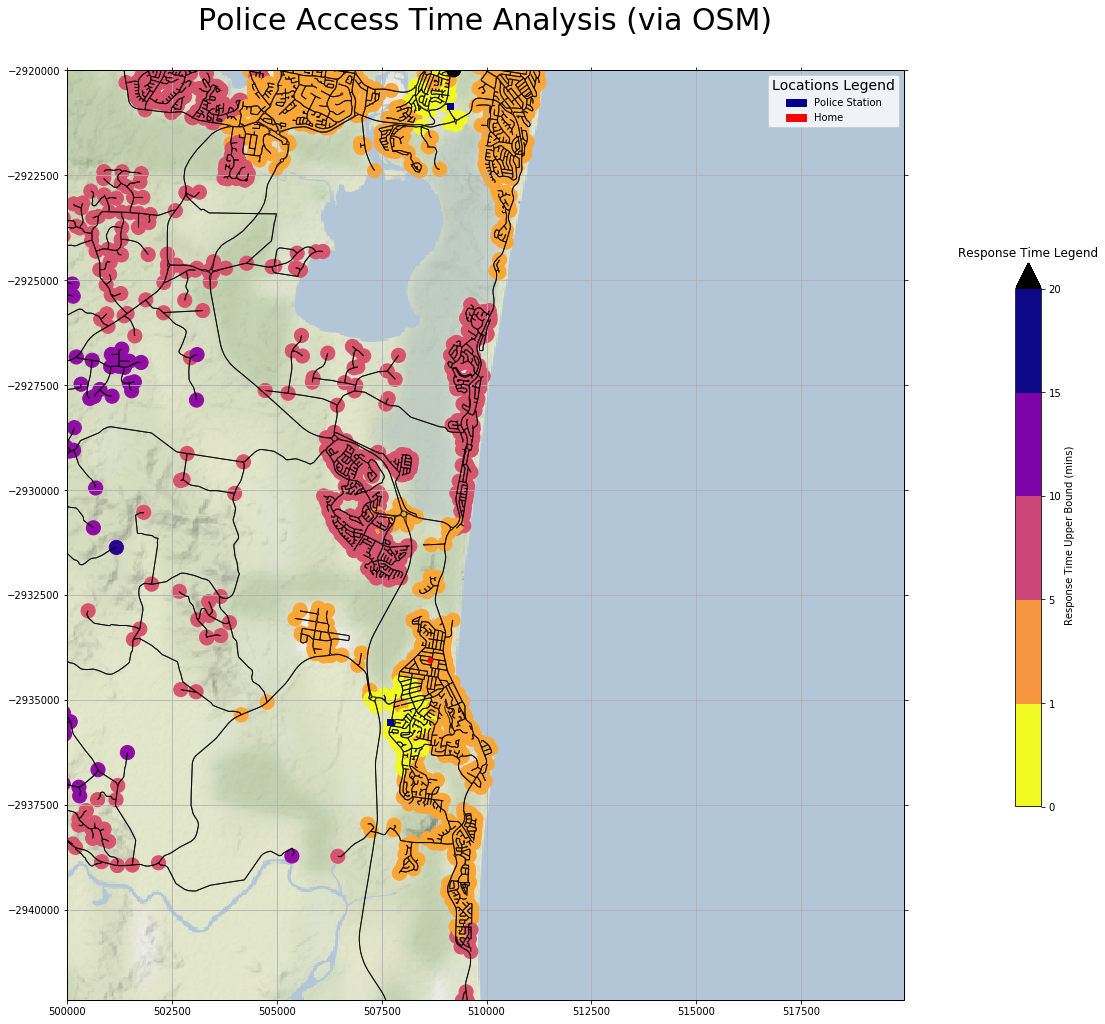

In [121]:
#  get OSM road network
graph = ox.graph_from_bbox(home[3], home[2], home[1], home[0], network_type='drive', truncate_by_edge=True, ) 

# create travel time attribute for edges
for u,v, k, data in graph.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_min
#end for

# convert to GDFs
n_df, e_df = ox.save_load.graph_to_gdfs(graph, nodes=True, edges=True)

LARGE = 1_000_000
e_df['access_time_bnd'] = LARGE
n_df['access_time_bnd'] = LARGE

# switch to UTM (so euclidean measurement works)
n_df = ox.projection.project_gdf(n_df)
e_df = ox.projection.project_gdf(e_df)

# set up Cartopy aware figure and Axes
fig = plt.figure(figsize=(20, 20) )
utm_crs = ccrs.UTM(e_df.crs['zone'], southern_hemisphere=False)
ax = fig.add_subplot(1, 1, 1, projection= utm_crs) 
ax.set_aspect('equal')
               
home = ( 153, 153.2, -26.6, -26.4) #home = ( 152.5, 153.5, -27, -26)
ax.set_extent(home, crs=ccrs.PlateCarree() )

# add spatial context
ax.add_image(imagery, 12, alpha=0.75)

# get access times
for pol_node in pol_nodes:
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(graph, pol_node, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            current = n_df.at[node, 'access_time_bnd']
            n_df.at[node, 'access_time_bnd'] = min(trip_time, current)
        #end for
    #end for
#end for


# set up color map to show black for unreachable nodes (LARGE trip times)
my_cmap = mcm.get_cmap(name='plasma_r')
my_cmap.set_under('white')
my_cmap.set_over('black')

#bounds = [1, 5, 10, 15, 20,]
bounds = [0, 1, 5, 10, 15, 20]
my_norm = mpc.BoundaryNorm(boundaries=bounds, ncolors=256)

# plot road network
e_df.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none', zorder=2, alpha=0.8, )
n_df.plot(ax=ax, 
          column='access_time_bnd', 
          cmap=my_cmap,
          markersize=200, 
          zorder=1, 
          vmax=trip_times[-1]+1,
         )


# plot marker with lon / lat
home_lat, home_lon = -26.527,153.08679
ax.plot(home_lon, home_lat, marker='o', transform=ccrs.PlateCarree(), markersize=5, alpha=1, color='red', zorder=5 )

# read police station locations
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
# project to UTM
police_df = police_df.to_crs(utm_crs.proj4_init)
# plot stations
police_df.plot(ax=ax, marker='s', color='darkblue', zorder=5, legend=True)

# set title and grid
label_utm_grid2(ax)
plt.title('Police Access Time Analysis (via OSM)', {'fontsize':30}, pad=40)

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=my_norm)
sm._A = []
cb = plt.colorbar(sm, shrink=0.5, pad=.1, extend='max')
cb.set_label('Response Time Upper Bound (mins)')

fig.axes[1].set_title('Response Time Legend')

names = []
handles = []

# for symbol, draw a patch, append handle to list, and append symbol name to names list

patch = mpatches.Patch(color='darkblue', label='Police Station')
handles.append(patch)
names.append('Police Station')
patch = mpatches.Patch(color='red', label='Home')
handles.append(patch)
names.append('Home')

# create legend
leg = ax.legend(handles, names)
leg.set_title('Locations Legend',prop={'size':14})


plt.show()

In [38]:
e_df.head()

,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,time,tunnel,u,v,width,access_time_bnd
0,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,0.059381,NaN,4367056896,4367056897,NaN,1000000
1,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,94.648,NaN,NaN,False,184866396,NaN,0.070986,NaN,4367056896,4367056187,NaN,1000000
2,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,78.167,NaN,NaN,False,184866396,NaN,0.058625,NaN,4367056896,1954348651,NaN,1000000
3,NaN,LINESTRING (506767.4073423255 -2931189.9548797...,residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,0.059381,NaN,4367056897,4367056896,NaN,1000000
4,NaN,LINESTRING (508628.4472333753 -2937240.5457182...,residential,NaN,0,NaN,75.478,NaN,Beryl Terrace,False,38070369,NaN,0.056608,NaN,447782914,447782917,NaN,1000000


In [39]:
n_df.head()

,highway,osmid,x,y,geometry,access_time_bnd
30886265,NaN,30886265,153.025,-26.4419,POINT (502443.8436991023 -2924620.866992281),1000000
30886314,NaN,30886314,153.024,-26.4423,POINT (502441.2535726101 -2924662.320410597),1000000
30886317,NaN,30886317,153.024,-26.4423,POINT (502402.0714833383 -2924662.30193895),1000000
30886345,NaN,30886345,153.025,-26.4422,POINT (502446.6485433009 -2924656.019734916),1000000
32940989,NaN,32940989,153.008,-26.5704,POINT (500826.3131321028 -2938858.074150953),1000000


In [25]:
LARGE = 1_000_000
e_df['access_time_bnd'] = LARGE
n_df['access_time_bnd'] = LARGE

In [43]:
trip_time = trip_times[0]
subgraph = nx.ego_graph(graph, pol_nodes[0], radius=trip_time, distance='time')
for node in subgraph.nodes():
    n_df.at[node, 'access_time_bnd'] = trip_time
#end for

In [45]:
list(subgraph.nodes())[0]

409456640

In [47]:
n_df.loc[409456640]

highway                                                     NaN
osmid                                                 409456640
x                                                        153.08
y                                                      -26.5318
geometry           POINT (507939.1118008929 -2934578.767925214)
access_time_bnd                                               1
Name: 409456640, dtype: object

In [49]:
for trip_time in sorted(trip_times, reverse=True):
    print(trip_time)
#end for

20
15
10
5
1


In [55]:
for edge in subgraph.edges():
    print(edge)
    break

(409456640, 409456695)


In [71]:
e_df['access_time_bnd'].unique()

array([1000000], dtype=int64)

In [60]:
subgraph

In [101]:
fuzz_df.head()

,geometry
0,POLYGON ((508238.3256851299 -2920902.139474874...


In [94]:
type(subgraph)


networkx.classes.multidigraph.MultiDiGraph

In [98]:
edge_lines = []
for n_fr, n_to in subgraph.edges():
    f = n_df.loc[n_fr].geometry
    t = n_df.loc[n_to].geometry
    edge_lines.append(LineString([f,t]) )
#end for
edges_gdf = gpd.GeoDataFrame(geometry=edge_lines)
fuzz = edges_gdf.buffer(25.0).unary_union

    

In [103]:
e_df.head()

,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,time,tunnel,u,v,width,access_time_bnd
0,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,0.059381,NaN,4367056896,4367056897,NaN,1000000
1,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,94.648,NaN,NaN,False,184866396,NaN,0.070986,NaN,4367056896,4367056187,NaN,1000000
2,NaN,"LINESTRING (506707.21220934 -2931241.27864803,...",residential,NaN,0,NaN,78.167,NaN,NaN,False,184866396,NaN,0.058625,NaN,4367056896,1954348651,NaN,1000000
3,NaN,LINESTRING (506767.4073423255 -2931189.9548797...,residential,NaN,0,NaN,79.175,NaN,NaN,False,439082595,NaN,0.059381,NaN,4367056897,4367056896,NaN,1000000
4,NaN,LINESTRING (508628.4472333753 -2937240.5457182...,residential,NaN,0,NaN,75.478,NaN,Beryl Terrace,False,38070369,NaN,0.056608,NaN,447782914,447782917,NaN,1000000


In [107]:
t, f = list(subgraph.edges())[0]

In [108]:
t,f

(5610480161, 5610480162)

In [112]:
mask1 = e_df['u']==t
mask2 = e_df['v']==f

mask3 = mask1 & mask2

zz = e_df[mask3].copy()

In [113]:
zz.head()

,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,time,tunnel,u,v,width,access_time_bnd
276,NaN,LINESTRING (509272.2979353695 -2921285.2261435...,unclassified,NaN,0,NaN,40.511,NaN,NaN,False,587347753,NaN,0.030383,NaN,5610480161,5610480162,NaN,1000000


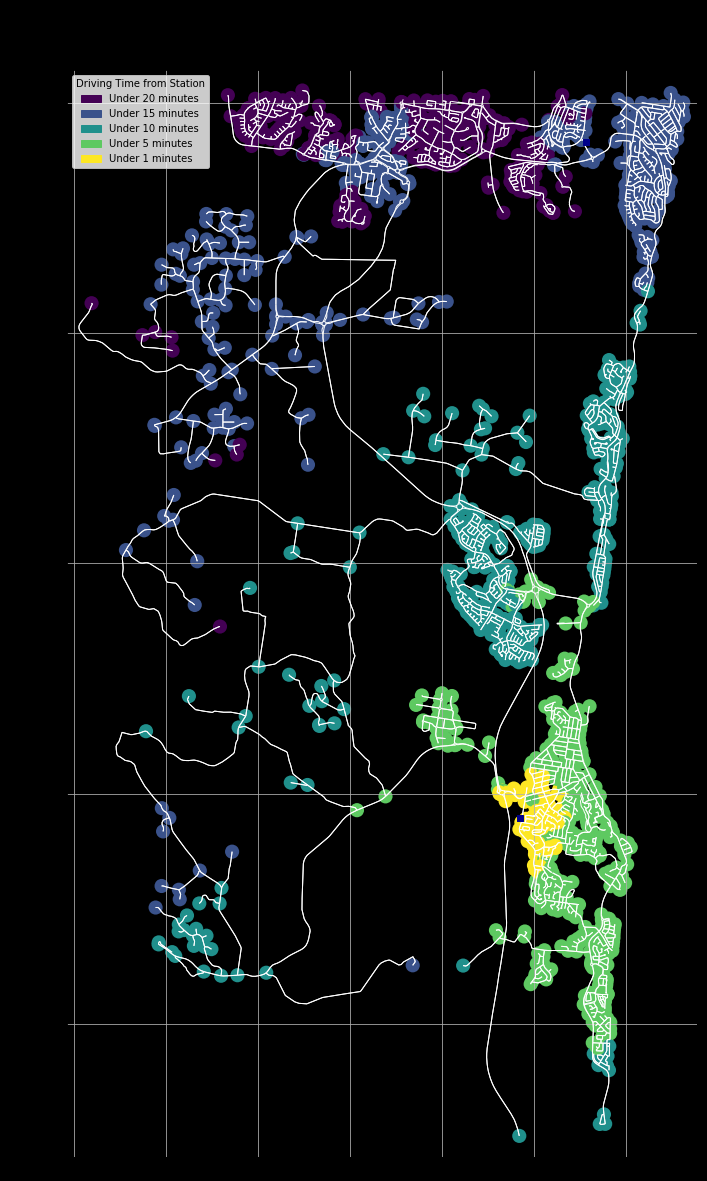

In [117]:
home = ( 153, 153.2, -26.6, -26.4) 
graph = ox.graph_from_bbox(home[3], home[2], home[1], home[0], network_type='drive', truncate_by_edge=True, ) 
graph = ox.project_graph(graph)

for u,v, k, data in graph.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_min
#end for

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph, pol_nodes[0], radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
    #end for
#end for
nc = [node_colors[node] if node in node_colors else 'none' for node in graph.nodes() ]
ns = [200 if node in node_colors else 0 for node in graph.nodes()]

# create a figure, and an axes in that figure
fig, ax = ox.plot_graph(graph, fig_height=20, 
                        node_color=nc, node_size=ns, node_zorder=1, node_alpha=1,
                        edge_color='white', bgcolor='black',  
                       show=False, save=False, close=False, axis_off=False,
                       )
ax.set_aspect('equal')


# read police station locations
station_file='D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
# project to UTM
police_df = police_df.to_crs(utm_crs.proj4_init)
# plot stations
police_df.plot(ax=ax, marker='s', color='darkblue', zorder=5, legend=True)


label_utm_grid2(ax)

# handles is a list of patch handles
handles = []
# names is the list of corresponding labels to appear in the legend
names = []

# for each cartopy defined color, draw a patch, append handle to list, and append color name to names list
for c, t  in zip(iso_colors, sorted(trip_times, reverse=True)):
    label = 'Under '+str(t)+' minutes'
    patch = mpatches.Patch(color=c, label=label)
    handles.append(patch)
    names.append(label)
#end for

ax.legend(handles, names, title='Driving Time from Station')
plt.title('Police "Closeness" Analysis', {'fontsize':30}, pad=40)


plt.show()
